In [1]:
import pandas as pd
import numpy as np
import re #used as a regular expression to find particular patterns and process it
import string 

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt

import nltk #a natural language processing toolkit module associated in anaconda
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,SnowballStemmer
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
# # uncomment these for the first run
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
# nltk.download('omw-1.4')
# nltk.download('wordnet')

In [2]:
df = pd.read_table('./data/review_sentiment.tsv')
df.drop(columns=df.columns[0], axis=1,  inplace=True)
df.head()

product_name                                      newReviewText Sentiment
0      Kosette                                     good and comfy  positive
1      Kosette  Bought for the whole family for the period of ...  positive
2      Kosette  It hurts the ears a little if you wear it for ...  negative
3      Kosette                          Pretty like after washing  positive
4      Kosette                                                  4  positive

In [3]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for word in r:
        input_txt = re.sub(word, "", input_txt)
    return input_txt


df['newReviewText'] = np.vectorize(remove_pattern)(df['newReviewText'].astype(str), "@[\w]*")

In [4]:
# Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

# Text-encoding: UTF-8 encoder
def to_unicode(text):
    if isinstance(text, float):
        text = str(text)
    if isinstance(text, int):
        text = str(text)
    if not isinstance(text, str):
        text = text.decode('utf-8', 'ignore')
    return text
# Removing emojis
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols                                                                         
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing the noisy text
def denoise_text(text):
    text = to_unicode(text)
    text = re.sub(r"http\S+", "", text)
    text = deEmojify(text)
    text = text.encode('ascii', 'ignore')
    text = to_unicode(text)
    text = remove_between_square_brackets(text)
    text = remove_special_characters(text)
    text = text.lower() # lower case 
    return text


In [5]:
df['newReviewText'] = df['newReviewText'].apply(denoise_text)

In [6]:
#Tokenization of text
tokenizer=ToktokTokenizer() #for every function

#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')
stopword_list.extend(['kf94','n95','don39t','mask','it39s','couldn39t','can39t','didn39t'])

In [7]:
from nltk.tokenize import word_tokenize,sent_tokenize

#You can either remove stopwords before or after stemming. But since this is a review context, we expect users to have used many different words and we did
# stemming before filtering for stopwords.

stop=set(stopwords.words('english'))
print(stop)

#Removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
        filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Apply function on review column
df['newReviewText']=df['newReviewText'].apply(remove_stopwords)

{'wouldn', 'do', 'during', 'as', 'any', 'than', 'wasn', "aren't", 'his', 's', 'down', 'isn', 'about', 'myself', "should've", 'their', 'so', 'it', "hasn't", 'out', "haven't", 'has', 'its', 'you', 'then', 'few', 'what', 'not', 'my', "isn't", 'needn', 'before', 'who', 'mustn', 'does', "you've", 'each', 'on', "wasn't", 'mightn', 'had', 'that', "needn't", 'were', 'have', 't', 'hers', 'of', "doesn't", "mustn't", 'd', 'shan', 'being', 'if', 'at', 'o', 'from', 'over', 'both', 'into', 'me', 'ain', 'having', 'll', 'but', 'off', 'are', 'no', 'where', 'weren', 'hasn', 'these', "wouldn't", 're', "didn't", 'ourselves', 'some', 'how', "she's", "couldn't", 'here', 'between', 'only', 'your', 'because', 'all', 'or', "mightn't", 'hadn', 'for', 'same', 'after', 'now', 'to', 'too', "you'll", 'until', 've', "won't", 'yours', 'when', 'there', 'once', 'her', 'more', 'nor', 'other', 'can', 'why', 'should', 'above', 'and', 'doing', 'under', 'just', "you'd", 'our', 'in', 'himself', "shan't", 'through', 'don', 's

In [8]:
df.head()

product_name                                      newReviewText Sentiment
0      Kosette                                         good comfy  positive
1      Kosette  bought whole family period pandemic comfortabl...  positive
2      Kosette                   hurts ears little wear long time  negative
3      Kosette                                pretty like washing  positive
4      Kosette                                                  4  positive

In [9]:
def simple_stemmer(text):
    ps = SnowballStemmer(language='english')
    return ' '.join([ps.stem(word) for word in tokenizer.tokenize(text)])

In [10]:
def lemmatize_all(sentence):
    wnl = WordNetLemmatizer()
    for word, tag in pos_tag(word_tokenize(sentence)):
        if tag.startswith("NN"):
            yield wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            yield wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            yield wnl.lemmatize(word, pos='a')
        else:
            yield word
            
def lemmatize_text(text):
    return ' '.join(lemmatize_all(text))

In [11]:
df['newReviewText'] = df['newReviewText'].apply(lemmatize_text)
df.head()

product_name                                      newReviewText Sentiment
0      Kosette                                         good comfy  positive
1      Kosette  bought whole family period pandemic comfortabl...  positive
2      Kosette                    hurt ears little wear long time  negative
3      Kosette                                   pretty like wash  positive
4      Kosette                                                  4  positive

In [12]:
pos_dict = dict()
neg_dict = dict()
for i in df.product_name.unique():
    pos_dict[i] = " ".join([sentence for sentence in df[(df['product_name']==i) & (df['Sentiment']=='positive')].newReviewText]).replace('mask','')
    neg_dict[i] = " ".join([sentence for sentence in df[(df['product_name']==i) & (df['Sentiment']=='negative')].newReviewText]).replace('mask','')

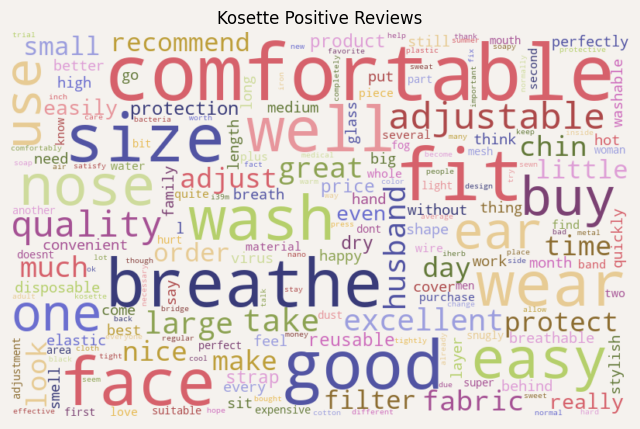

In [36]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#f5f2eeff",colormap='tab20b',collocations=False).generate(pos_dict['Kosette'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#f5f2eeff')
plt.title('Kosette Positive Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

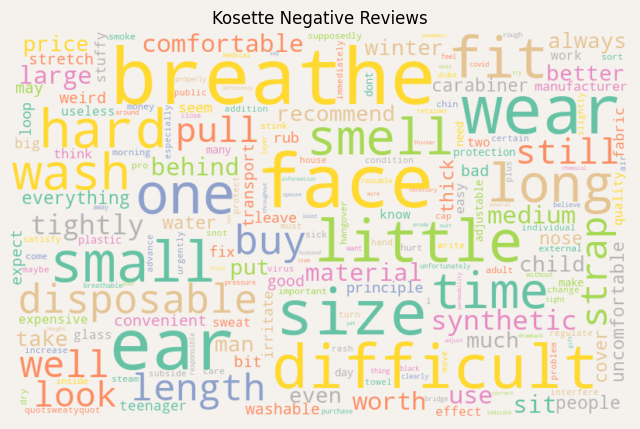

In [37]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#f5f2eeff",colormap='Set2',collocations=False).generate(neg_dict['Kosette'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#f5f2eeff')
plt.title('Kosette Negative Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

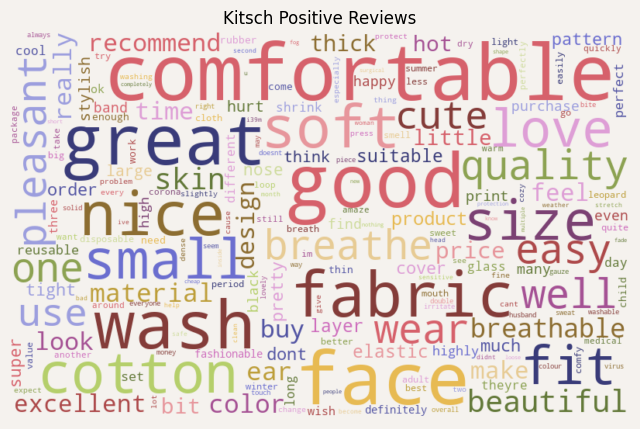

In [38]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#f5f2eeff",colormap='tab20b',collocations=False).generate(pos_dict['Kitsch'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#f5f2eeff')
plt.title('Kitsch Positive Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

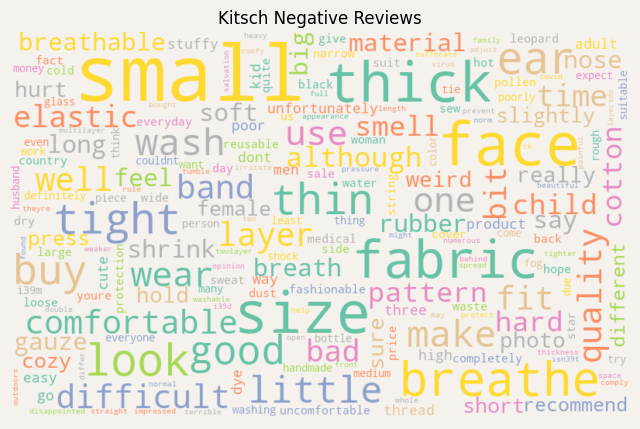

In [46]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#f5f2eeff",colormap='Set2',collocations=False).generate(neg_dict['Kitsch'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#f5f2eeff')
plt.title('Kitsch Negative Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

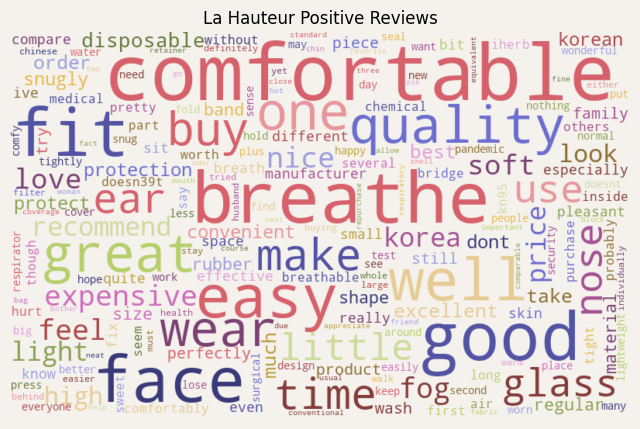

In [39]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#f5f2eeff",colormap='tab20b',collocations=False).generate(pos_dict['La Hauteur'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#f5f2eeff')
plt.title('La Hauteur Positive Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

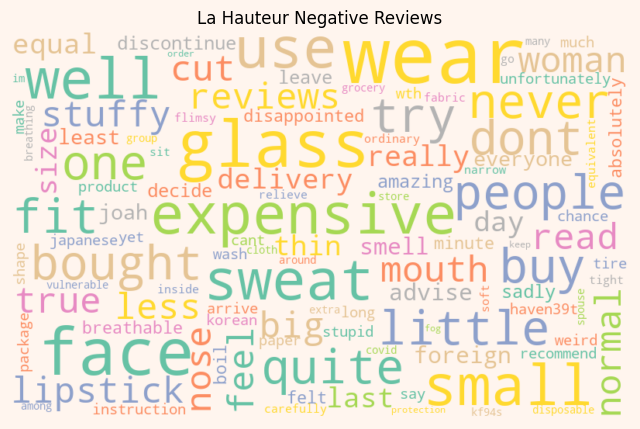

In [18]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#FFF5EE",colormap='Set2',collocations=False).generate(neg_dict['La Hauteur'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#FFF5EE')
plt.title('La Hauteur Negative Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

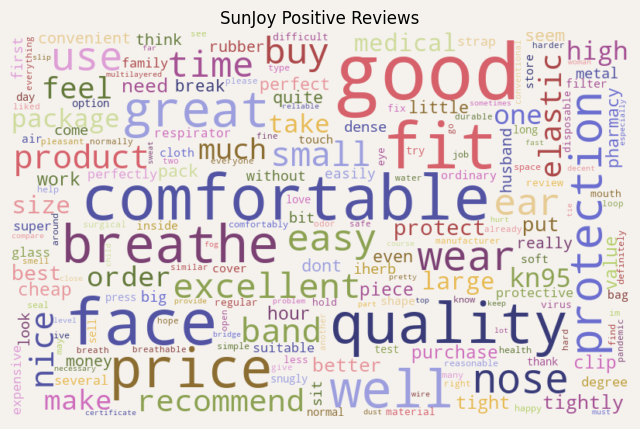

In [40]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#f5f2eeff",colormap='tab20b',collocations=False).generate(pos_dict['SunJoy'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#f5f2eeff')
plt.title('SunJoy Positive Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

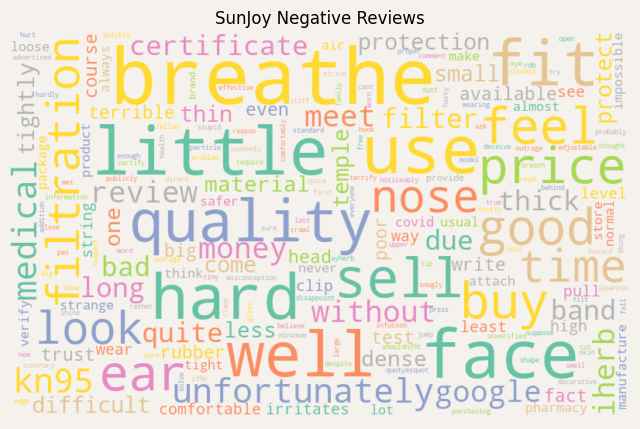

In [45]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#f5f2eeff",colormap='Set2',collocations=False).generate(neg_dict['SunJoy'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#f5f2eeff')
plt.title('SunJoy Negative Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

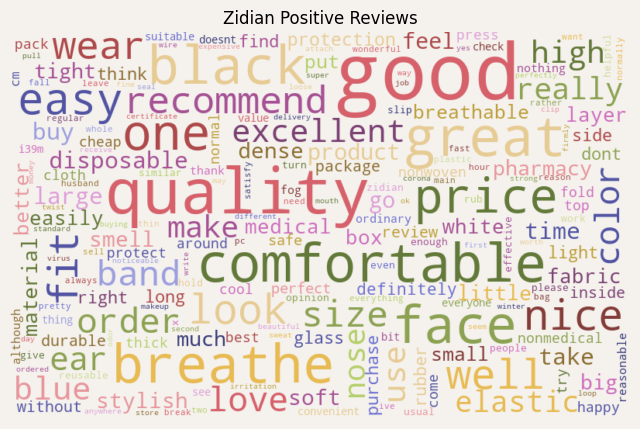

In [41]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#f5f2eeff",colormap='tab20b',collocations=False).generate(pos_dict['Zidian'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#f5f2eeff')
plt.title('Zidian Positive Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

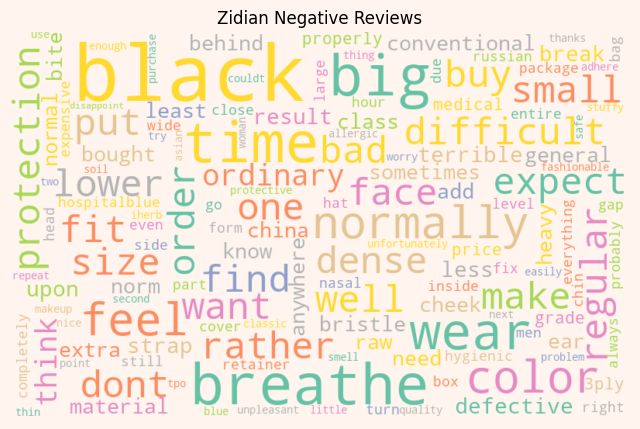

In [22]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#FFF5EE",colormap='Set2',collocations=False).generate(neg_dict['Zidian'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#FFF5EE')
plt.title('Zidian Negative Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [23]:
'One Fine Day', 'Landsberg', 'Dr. Puri', 'Puritas', 'Now Foods'

('One Fine Day', 'Landsberg', 'Dr. Puri', 'Puritas', 'Now Foods')

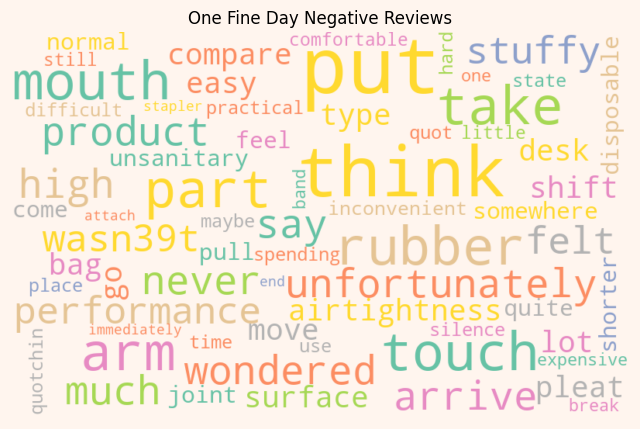

In [24]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#FFF5EE",colormap='Set2',collocations=False).generate(neg_dict['One Fine Day'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#FFF5EE')
plt.title('One Fine Day Negative Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

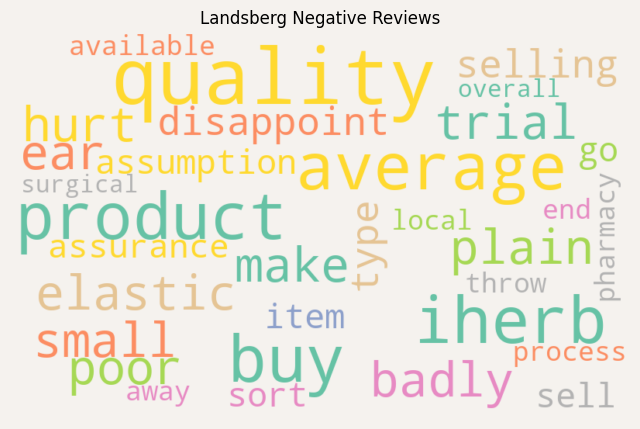

In [43]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#f5f2eeff",colormap='Set2',collocations=False).generate(neg_dict['Landsberg'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#f5f2eeff')
plt.title('Landsberg Negative Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

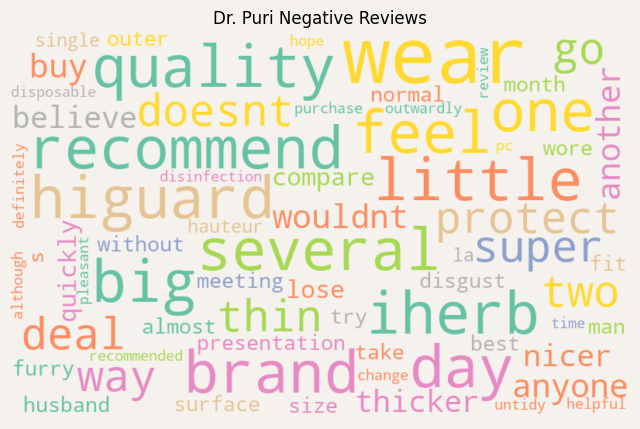

In [44]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#f5f2eeff",colormap='Set2',collocations=False).generate(neg_dict['Dr. Puri'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#f5f2eeff')
plt.title('Dr. Puri Negative Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

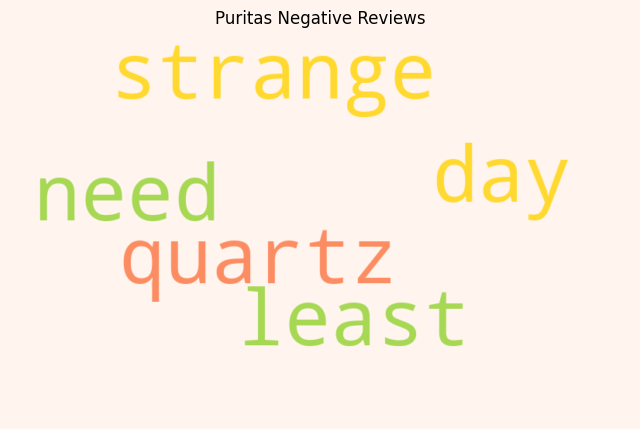

In [27]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#FFF5EE",colormap='Set2',collocations=False).generate(neg_dict['Puritas'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#FFF5EE')
plt.title('Puritas Negative Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

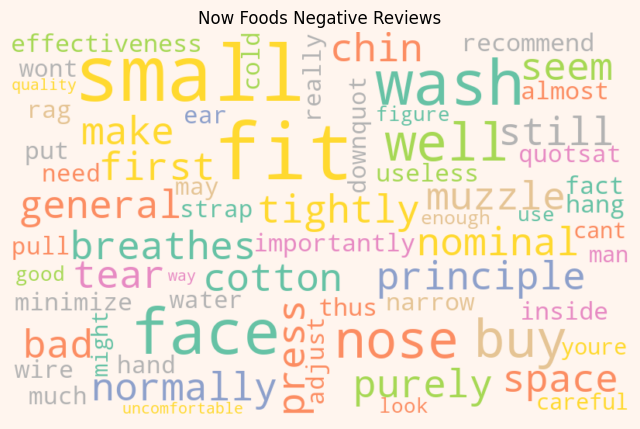

In [28]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#FFF5EE",colormap='Set2',collocations=False).generate(neg_dict['Now Foods'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#FFF5EE')
plt.title('Now Foods Negative Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

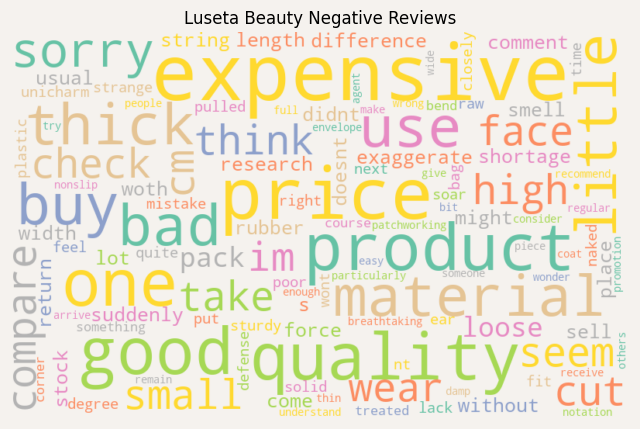

In [42]:
wordcloud = WordCloud(
    width=800, height=500, random_state=42, max_font_size=100,
    background_color="#f5f2eeff",colormap='Set2',collocations=False).generate(neg_dict['Luseta Beauty'])

# plot the graph
plt.figure(figsize=(8,8),facecolor='#f5f2eeff')
plt.title('Luseta Beauty Negative Reviews')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()